<a href="https://colab.research.google.com/github/cyberholics/Image-classification-with-Pytorch/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from PIL import Image
import cv2, glob, numpy as np, pandas as pd
from glob import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# load the pretrained model

model = models.vgg19(pretrained=True).to(device)
summary(model, (3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.7MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# set up kaggle authentication for colab
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
!kaggle datasets download -d sujaykapadnis/smoking # download data

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/smoking
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
!unzip smoking.zip # unzip the data


In [7]:
train_data_directory = '/content/Training/Training'
test_data_directory = '/content/Testing/Testing'

In [88]:
# dataset class
class SmokingDataset(Dataset):
  def __init__(self, directory):
    smoking = glob(os.path.join(directory + '/smoking_*.jpg'))
    notsmoking = glob(os.path.join(directory + '/notsmoking_*.jpg'))
    self.fpaths = smoking[:200] + notsmoking[:200]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    from random import shuffle, seed
    seed(10)
    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('smoking') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return im.float().to(device), torch.tensor([target]).float().to(device)


tensor([0.], device='cuda:0')


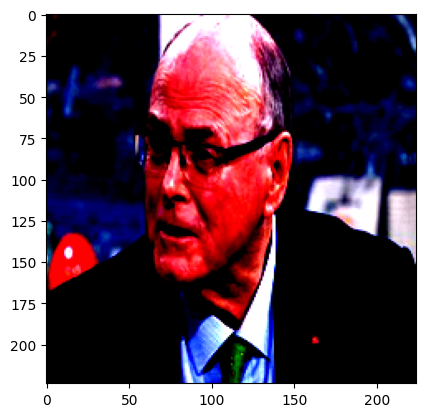

In [89]:
# view sample data
train_data = SmokingDataset(train_data_directory)
im, label = train_data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [96]:
# using pretrained model

def get_model():
  model = models.vgg16(pretrained=True).to(device)
  for parameters in model.paramerts():
    parameters.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.Dropout(0.2),
  nn.Linear(128, 1),
  nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model.to(device), loss_fn, optimizer

In [97]:
# train the model in batches
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y.unsqueeze(1))
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [98]:
# validation in batches
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [99]:
# load data in batches

def get_data():
  train = SmokingDataset(train_data_directory)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
  drop_last = True)
  val = SmokingDataset(test_data_directory)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [ ]:
#initialize the data and model function
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [83]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f" epoch {epoch + 1}/5")

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    #Training Phase
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Train model on batch and get loss
        train_epoch_losses.append(batch_loss)

    # Calculate average training loss for the epoch
    train_epoch_loss = np.array(train_epoch_losses).mean()

    # Training Accuracy Phase
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)  # Evaluate model accuracy on batch
        train_epoch_accuracies.extend(is_correct)

    # Calculate average training accuracy for the epoch
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Validation Accuracy Phase
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)  # Evaluate model on validation data
        val_epoch_accuracies.extend(val_is_correct)

    # Calculate average validation accuracy for the epoch
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [87]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
